#  Segmentation

A very basic introduction to using segmentation models with OpenVINO.

We use the pre-trained [road-segmentation-adas-0001](https://docs.openvinotoolkit.org/latest/omz_models_model_road_segmentation_adas_0001.html) model from the [Open Model Zoo](https://github.com/openvinotoolkit/open_model_zoo/). ADAS stands for Advanced Driver Assistance Services. The model recognizes four classes: background, road, curb and mark.

## Imports

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import sys
from openvino.inference_engine import IECore

sys.path.append("../utils")
from notebook_utils import segmentation_map_to_image

## Load the Model

In [2]:
ie = IECore()

net = ie.read_network(
    model="model/road-segmentation-adas-0001.xml")
exec_net = ie.load_network(net, "CPU")

output_layer_ir = next(iter(exec_net.outputs))
input_layer_ir = next(iter(exec_net.input_info))

## Load an Image
A sample image from the [Mapillary Vistas](https://www.mapillary.com/dataset/vistas) dataset is provided. 

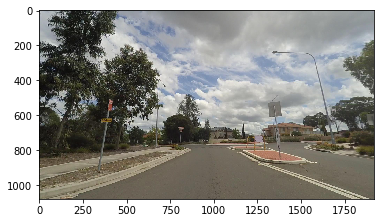

In [3]:
# The segmentation network expects images in BGR format
image = cv2.imread("data/empty_road_mapillary.jpg")

rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_h, image_w, _ = image.shape

# N,C,H,W = batch size, number of channels, height, width
N, C, H, W = net.input_info[input_layer_ir].tensor_desc.dims

# OpenCV resize expects the destination size as (width, height)
resized_image = cv2.resize(image, (W, H))

# reshape to network input shape
input_image = np.expand_dims(
    resized_image.transpose(2, 0, 1), 0
)  
plt.imshow(rgb_image)

## Do Inference

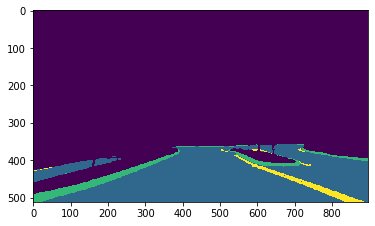

In [4]:
# Run the infernece
result = exec_net.infer(inputs={input_layer_ir: input_image})
result_ir = result[output_layer_ir]

# Prepare data for visualization
segmentation_mask = np.argmax(result_ir, axis=1)
plt.imshow(segmentation_mask[0])

## Prepare Data for Visualization

In [5]:
# Define colormap, each color represents a class
colormap = np.array([[68, 1, 84], [48, 103, 141], [53, 183, 120], [199, 216, 52]])

# Define the transparency of the segmentation mask on the photo
alpha = 0.3

# Use function from notebook_utils.py to transform mask to an RGB image
mask = segmentation_map_to_image(segmentation_mask, colormap)
resized_mask = cv2.resize(mask, (image_w, image_h))

# Create image with mask put on
image_with_mask = cv2.addWeighted(resized_mask, alpha, rgb_image, 1 - alpha, 0)

## Visualize data

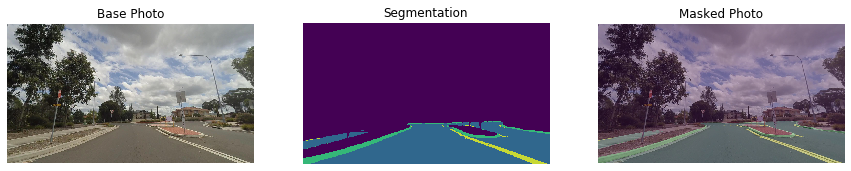

In [6]:
# Define titles with images
data = {"Base Photo": rgb_image, "Segmentation": mask, "Masked Photo": image_with_mask}

# Create subplot to visualize images
f, axs = plt.subplots(1, len(data.items()), figsize=(15, 10))

# Fill subplot
for ax, (name, image) in zip(axs, data.items()):
    ax.axis('off')
    ax.set_title(name)
    ax.imshow(image)

# Display image
plt.show(f)